In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

import missingno as msno

import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

## Load data from kaggle


In [2]:
import os
from pathlib import Path

_data_root = os.path.join("./../", 'data')
_data_root_raw = os.path.join(_data_root, 'raw')

In [3]:
isExist = os.path.exists(f"{_data_root}/store-sales-time-series-forecasting.zip")
if not isExist:
    !kaggle competitions download -c store-sales-time-series-forecasting -p {_data_root} --force

!unzip -o {_data_root}/"store-sales-time-series-forecasting.zip" -d {_data_root}
!mv {_data_root + "/*.csv"} {_data_root_raw}

Archive:  ./../data/store-sales-time-series-forecasting.zip
  inflating: ./../data/holidays_events.csv  
  inflating: ./../data/oil.csv       
  inflating: ./../data/sample_submission.csv  
  inflating: ./../data/stores.csv    
  inflating: ./../data/test.csv      
  inflating: ./../data/train.csv     
  inflating: ./../data/transactions.csv  


In [4]:
holidays_events = pd.read_csv(
    f"{_data_root_raw}/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    f"{_data_root_raw}/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)



Check for null data:

In [5]:
store_sales.isna().sum()

sales          0
onpromotion    0
dtype: int64

In [6]:
holidays_events.isna().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

<AxesSubplot: >

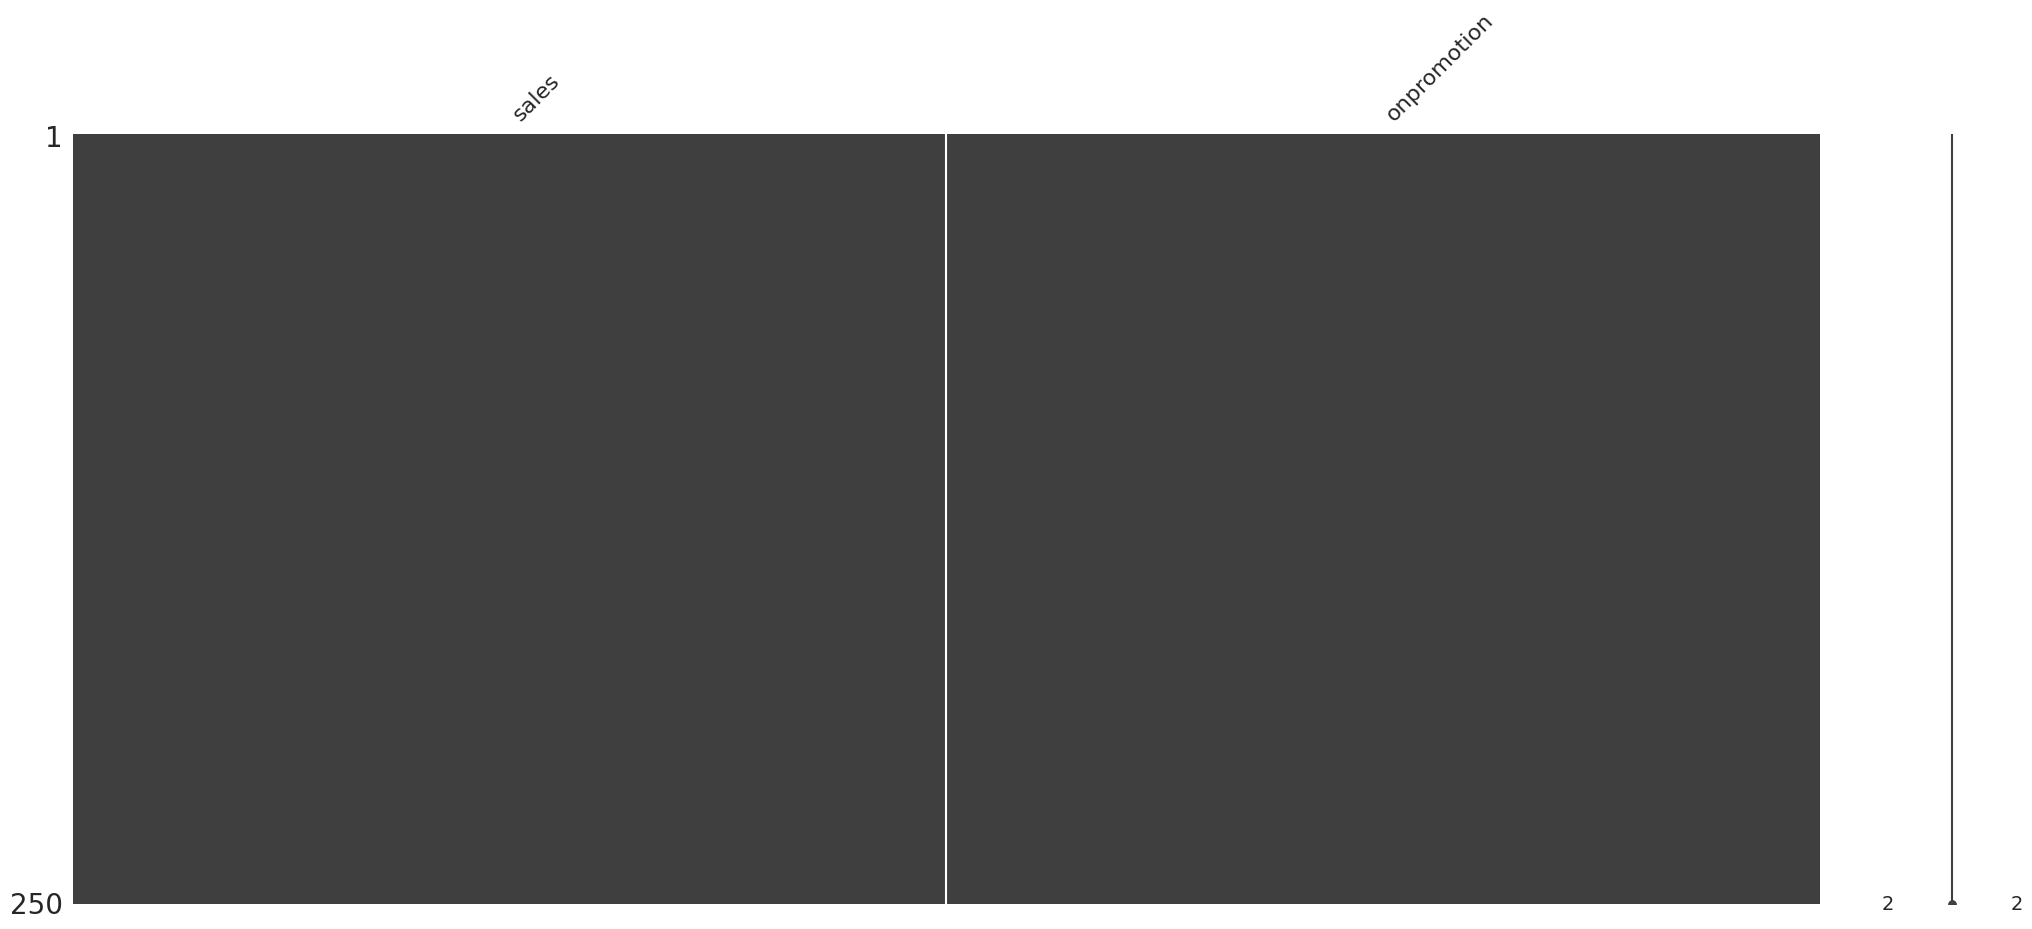

In [7]:
%matplotlib inline
msno.matrix(store_sales.sample(250))

<AxesSubplot: >

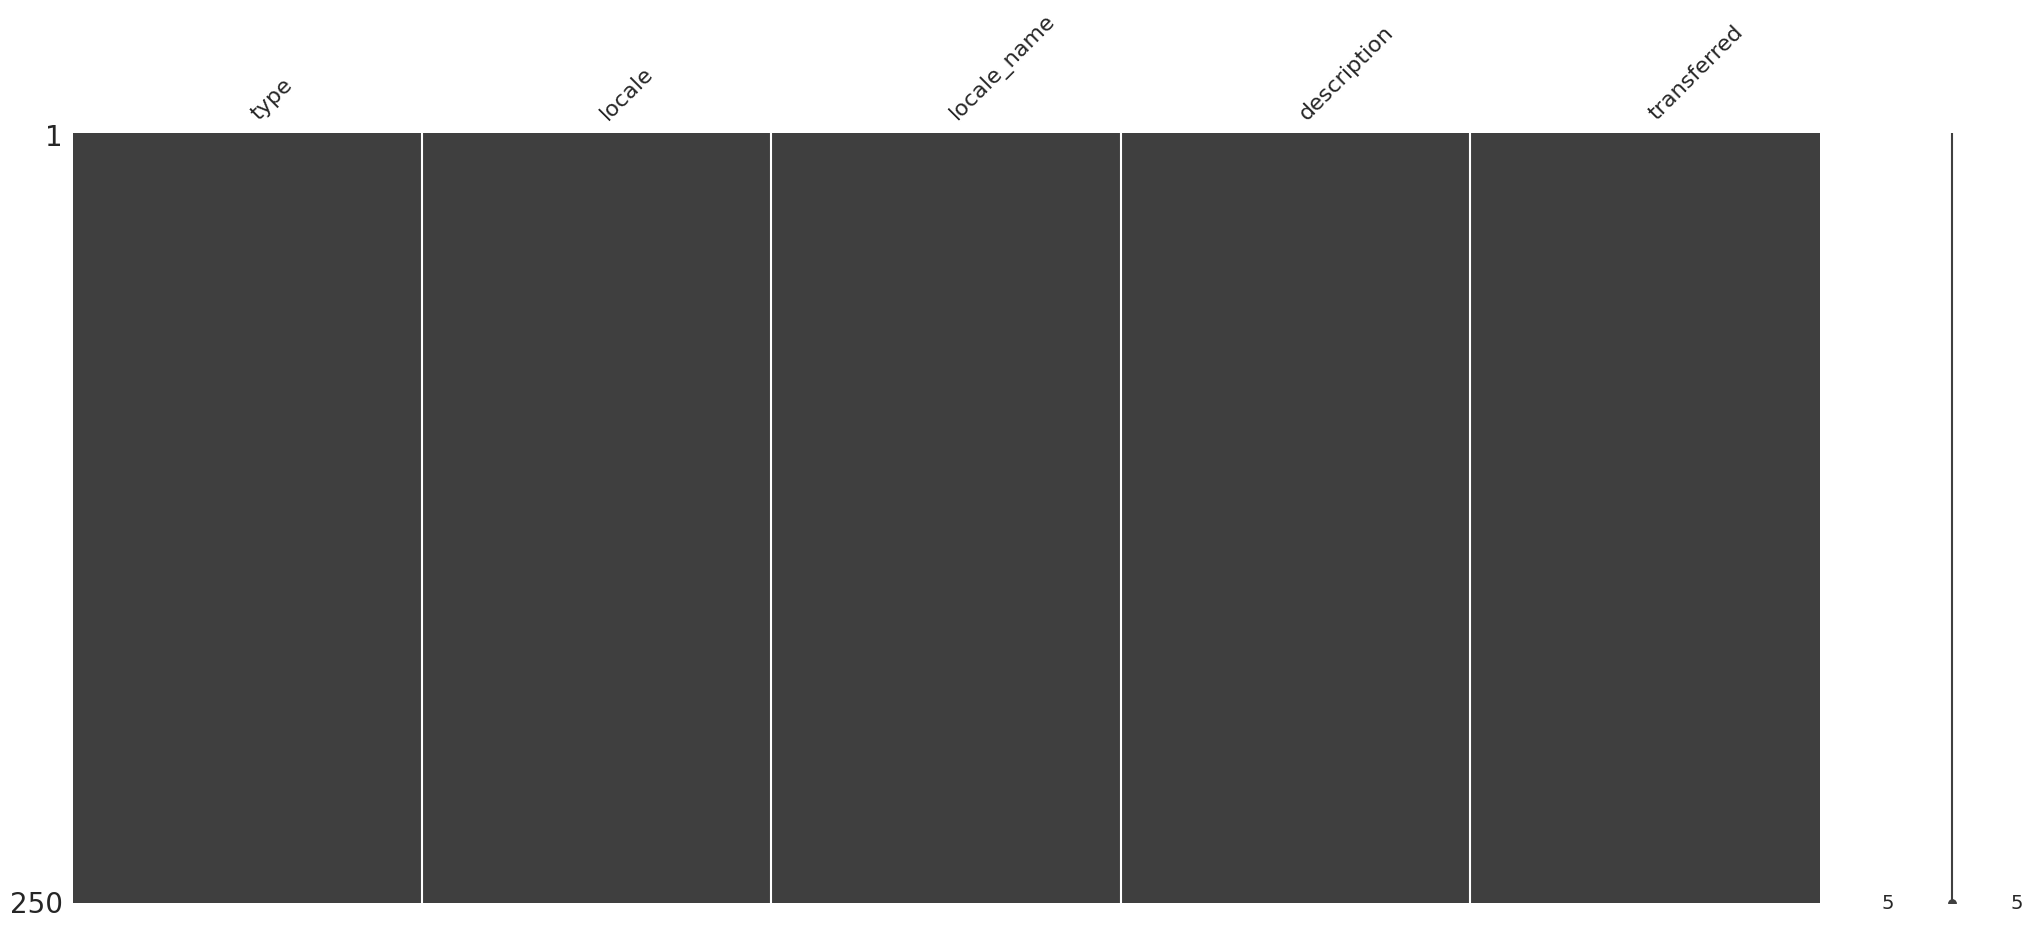

In [8]:
%matplotlib inline
msno.matrix(holidays_events.sample(250))

In [9]:
family_2017_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc[:, ['sales', 'onpromotion']]
)


<AxesSubplot: xlabel='date'>

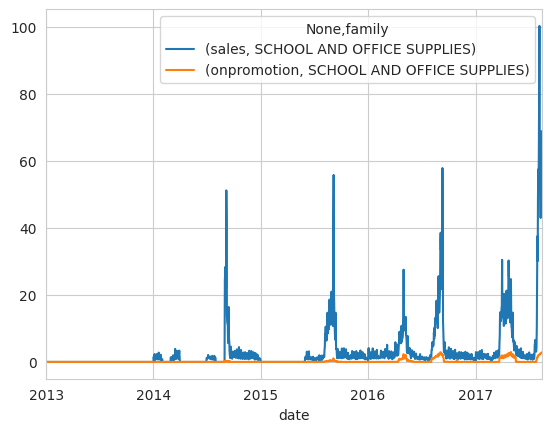

In [10]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
supply_sales.plot()


Check for seasonality

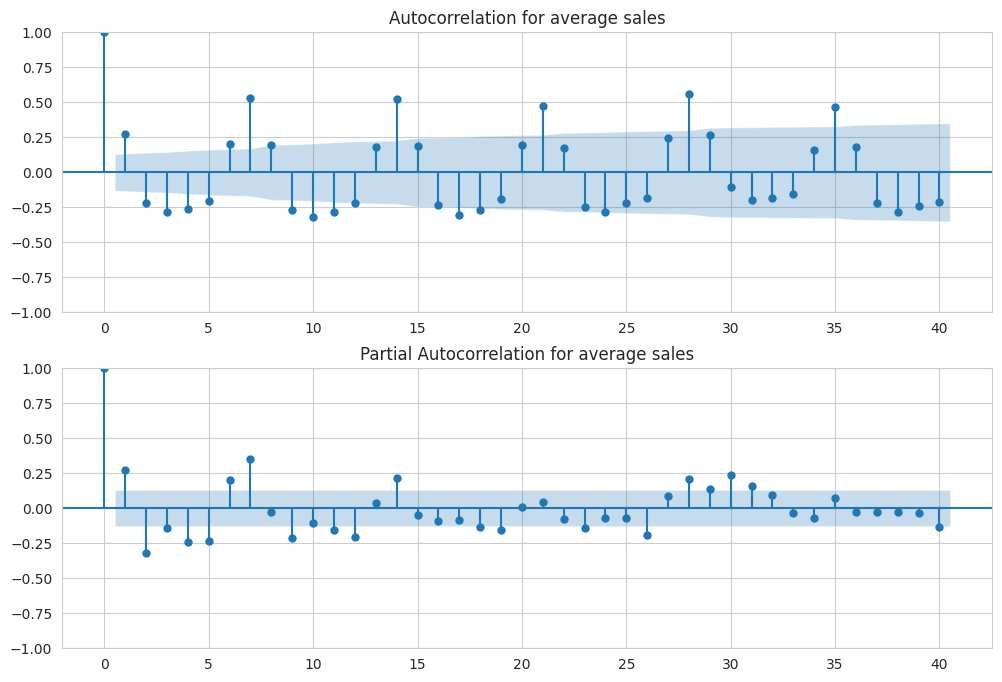

In [21]:
X = average_sales["sales"]
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1, title="Autocorrelation for average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2, title="Partial Autocorrelation for average sales")



We see that there is strong seasonality ( lag-1, lag-7 (weekly)

Try Determnistic process, to capture seasonality

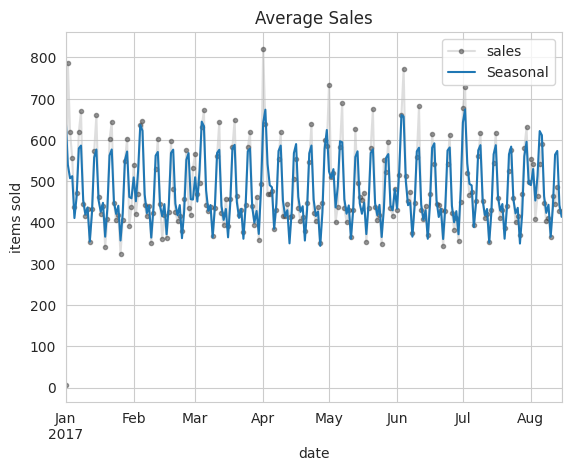

In [17]:
y = average_sales.copy()["sales"]

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name="y_pred"
)
#y_pred = pd.Series(mo)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Plot
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Deseasonalized values:

Text(0.5, 1.0, 'Average Sales (deseasonalized) ')

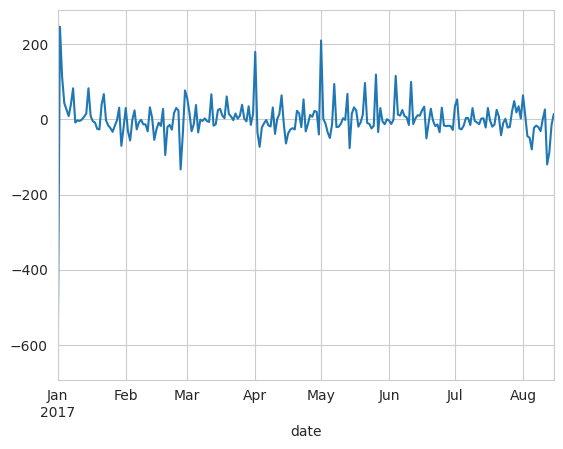

In [18]:
y_deseason = y - y_pred
y_deseason.name = 'average_sales_deseasoned'

y_deseason.plot()
ax.set_title("Average Sales (deseasonalized) ")

Check for aurocorrelation and lags for deseasonalized series:

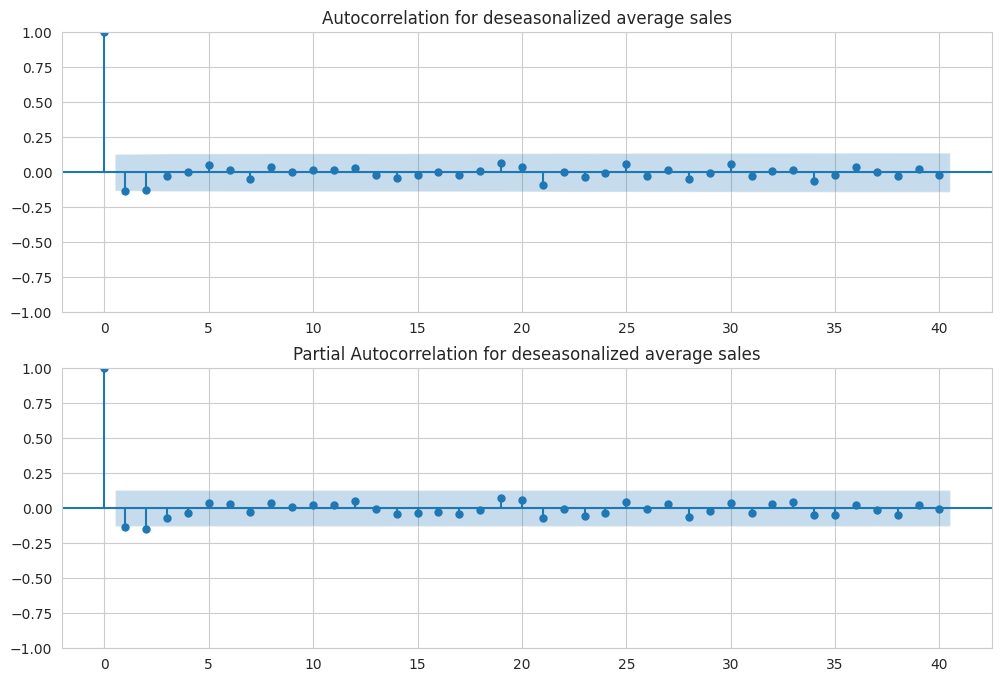

In [20]:
X = y_deseason
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1, title="Autocorrelation for deseasonalized average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2, title="Partial Autocorrelation for deseasonalized average sales")

There is no significant correlation between lagged average_sales and current average_sales

In [22]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [ ]:
onpromotion = average_sales["onpromotion"]
# take only values where promotion is present

onpromotion = onpromotion.loc[onpromotion > 1]
y
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1, title="Autocorrelation for average sales")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2, title="Partial Autocorrelation for average sales")